In [19]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


## Аннотация

Цель работы — спрогнозировать 120-дневный LTV клиента интернет-магазина (EV = вероятность покупки × ожидаемая сумма) и разложить базу по управляемым сегментам для маркетинга. Используем исторические заказы до отсечки T, удерживаем причинность (train ≤ T, val ∈ (T, T+H]), H = 120 дней и буфером на доставку. 

Задачи: (1) Сбор признаков на уровне клиента, (2) двухстадийный прогноз LTV (классификация: вероятность покупки + регрессия суммы), (3) временная кросс-валидация(4 фолда), (4) гибридная сегментация (rules + K-Means) и бизнес-рекомендации.

In [1]:
import os
import pandas as pd
import kagglehub
from datetime import timedelta
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    mean_absolute_error, root_mean_squared_error
)

## Описание датасета
В рамках анализа в работе используется датасет Olist (Brazilian e-commerce). Olist — бразильская платформа для малого и среднего бизнеса, которая агрегирует продавцов и выводит их товары на крупные маркетплейсы (модель marketplace-as-a-service). Продавцы подключаются к Olist, а заказы, оплата, логистика и пост-продажный сервис проходят через единую инфраструктуру Olist. Публичный датасет на Kaggle — это обезличенный дамп заказов Olist Store за ~2 года, предназначенный для академических и продуктовых исследований.

Состав датасета (основные таблицы)

orders — заказы (статус, метки времени: покупка/апрув/отгрузка/доставка/ETA). ~99,4k строк.

order_items — позиции в заказах (товар, продавец, цена, freight_value). Несколько строк на заказ.

order_payments — платежи (тип, число платежей, сумма). Возможны несколько платежей на один заказ.

order_reviews — отзывы (оценка 1–5, дата создания/ответа, опциональный текст).

customers — покупатели (внутренний customer_id, устойчивый customer_unique_id, город/штат, индекс-префикс).

products — товары (габариты, вес, категория) + product_category_name_translation (EN-переводы).

sellers — продавцы (город/штат).

geolocation — справочник координат по индексам (для гео-аналитики).

## Загрузка датасета
Загрузим датасеты brazilian-ecommerce для анализа из внешнего источника данных

In [3]:
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Path to dataset files: /Users/anastasiavelikanova/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2


In [5]:
# путь к папке с датасетом
path = "/Users/anastasiavelikanova/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2"

# посмотрим список файлов
print(os.listdir(path))

['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']


Для дальнейшего анализа и расчета LTV мне понадобятся данные о заказах, платежах, клиентах, отзывах, а также товарах. 
olist_orders_dataset.csv → заказы
olist_order_payments_dataset.csv → платежи
olist_customers_dataset.csv → клиенты
olist_order_reviews_dataset.csv → отзывы
olist_order_items_dataset.csv → для категорий товаров

Загрузим необходимые файлы для дальнейшего анализа и проверим их на наличие пропусков. Проанализируем структуру, типы данных в датасете и их особенности.

In [7]:
path = "/Users/anastasiavelikanova/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2"

# Загружаем каждый файл отдельно
orders    = pd.read_csv(os.path.join(path, "olist_orders_dataset.csv"))
payments  = pd.read_csv(os.path.join(path, "olist_order_payments_dataset.csv"))
customers = pd.read_csv(os.path.join(path, "olist_customers_dataset.csv"))
reviews   = pd.read_csv(os.path.join(path, "olist_order_reviews_dataset.csv"))
items     = pd.read_csv(os.path.join(path, "olist_order_items_dataset.csv"))

# Смотрим краткую информацию по каждому
print("\n==== ORDERS ====")
print(orders.info(), "\n")
print(orders.isna().sum(), "\n")

print("\n==== PAYMENTS ====")
print(payments.info(), "\n")
print(payments.isna().sum(), "\n")

print("\n==== CUSTOMERS ====")
print(customers.info(), "\n")
print(customers.isna().sum(), "\n")

print("\n==== REVIEWS ====")
print(reviews.info(), "\n")
print(reviews.isna().sum(), "\n")

print("\n==== ITEMS ====")
print(items.info(), "\n")
print(items.isna().sum(), "\n")


==== ORDERS ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_del

## Предобратка датасета

Для начала подготовим к дальнейшему анализу таблицу orders. 
Переведем столбцы, связанные с датой, из типа данных object в верный формат datetime

In [9]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [11]:
#Перевод столбцов в формат даты
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
orders["order_approved_at"] = pd.to_datetime(orders["order_approved_at"])
orders["order_delivered_carrier_date"] = pd.to_datetime(orders["order_delivered_carrier_date"])
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"])
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"])

В таблице с заказами есть пропуски в датах: order_approved_at, order_delivered_carrier_date, order_delivered_customer_date. Мы не будем удалять пропуски, так как они несут важное значение для дальнейшего анализа. 
order_approved_at → NaN = заказ был оформлен, но не прошёл подтверждение → значит, фактической выручки от него нет.
order_delivered_carrier_date → NaN = продавец/склад не передал заказ перевозчику → заказ завис.
order_delivered_customer_date → NaN = клиент не получил заказ → доход не засчитан.
Это важная бизнес-информация: одни клиенты стабильно завершают заказы, другие часто бросают их на полпути.

In [13]:
print(orders["order_id"].duplicated().sum())

0


Теперь произведем необходимые модификации с таблицей payments. По информации из датасетов выше, в таблице orders содержится 99 441 строк, когда как в таблице payments содержится 103 886 строк. То есть, предположительно, один заказ может быть оплачен несколькими платежами 

In [15]:
print("Всего строк в payments:", len(payments))
print("Уникальных order_id:", payments["order_id"].nunique())
print("Предположительно повторяющихся order_id:", len(payments) - payments["order_id"].nunique())

Всего строк в payments: 103886
Уникальных order_id: 99440
Предположительно повторяющихся order_id: 4446


In [17]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Суммируем платежи по заказу, чтобы получить общую сумму заказа (order_total_payment).

In [19]:
payments_agg = payments.groupby("order_id", as_index=False)["payment_value"].sum()
payments_agg.rename(columns={"payment_value": "order_total_payment"}, inplace=True)

In [21]:
payments_agg

,order_id,order_total_payment
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...,...
99435,fffc94f6ce00a00581880bf54a75a037,343.40
99436,fffcd46ef2263f404302a634eb57f7eb,386.53
99437,fffce4705a9662cd70adb13d4a31832d,116.85
99438,fffe18544ffabc95dfada21779c9644f,64.71


In [23]:
payments_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99440 entries, 0 to 99439
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_id             99440 non-null  object 
 1   order_total_payment  99440 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


In [ ]:
Как мы видим, теперь количество строк в датасете payments после группировки равно количеству строк в датасете orders.

Далее рассмотрим датасет CUSTOMERS. 
В этом датасете нет пропусков, он правктически готов к анализу. Особенность этого датасета - customer_id уникален в таблице и используется в связке с датасетом ORDERS, а customer_unique_id может повторяться (если клиент делал несколько заказов).

In [25]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [27]:
print("Уникальных customer_id:", customers["customer_id"].nunique())
print("Уникальных customer_unique_id:", customers["customer_unique_id"].nunique())

Уникальных customer_id: 99441
Уникальных customer_unique_id: 96096


Теперь перейдем к предподготовке таблицы REVIEWS. Особенностью данного датасета является отсутсиве пропусков в колонке review_score, которая содержит оценку заказа от 1 до 5. Эту означает, что эту метрику можно использовать для анализа удовлетворенности покупателей как ключевую. 
В колонках:
review_comment_title → почти все пустые (~88%).
review_comment_message → более половины пустые (~58%)

In [29]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [31]:
# 1) Приводим даты к datetime
reviews["review_creation_date"] = pd.to_datetime(reviews["review_creation_date"], errors="coerce")
reviews["review_answer_timestamp"] = pd.to_datetime(reviews["review_answer_timestamp"], errors="coerce")

# 2) Проверим распределение оценок
print("Распределение оценок (review_score):")
print(reviews["review_score"].value_counts(normalize=True).sort_index() * 100)

# 3) Считаем, сколько отзывов с текстом / без текста
with_title = reviews["review_comment_title"].notna().sum()
with_message = reviews["review_comment_message"].notna().sum()
total = len(reviews)

print(f"\nИз {total:,} отзывов:")
print(f"- с заголовком: {with_title:,} ({with_title/total:.1%})")
print(f"- с текстом:    {with_message:,} ({with_message/total:.1%})")
print(f"- только оценка: {(total - with_message):,} ({(total - with_message)/total:.1%})")

# 4) Быстрый просмотр
print("\nПример отзывов:")
print(reviews.head(3))

Распределение оценок (review_score):
review_score
1    11.513344
2     3.175643
3     8.242965
4    19.291704
5    57.776344
Name: proportion, dtype: float64

Из 99,224 отзывов:
- с заголовком: 11,568 (11.7%)
- с текстом:    40,977 (41.3%)
- только оценка: 58,247 (58.7%)

Пример отзывов:
                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   

   review_score review_comment_title review_comment_message  \
0             4                  NaN                    NaN   
1             5                  NaN                    NaN   
2             5                  NaN                    NaN   

  review_creation_date review_answer_timestamp  
0           2018-01-18     2018-01-18 21:46:59  
1           2018-03-10     2018-03-11 03:05:13  
2           2018-0

Выделим последний отзыв по каждому заказу (так как будем агрегировать на уровне заказа для дальнейшего анализа). Берем наиболее актуальный отзыв по заказу - последний по времени

In [33]:
# Нам для order-level дальше нужна только итоговая оценка по заказу.
# Берём последний по времени ответа отзыв и оставляем только оценку.
reviews_min = (
    reviews.sort_values(["order_id", "review_answer_timestamp"])
           .groupby("order_id", as_index=False)
           .tail(1)[["order_id", "review_score"]]
)

assert reviews_min["order_id"].is_unique, "В reviews_min должен быть 1 отзыв на заказ"

Теперь обработаем датасет items. Здесь приведем дату к datetime, а также агрегируем на уровне заказа — это нужно для возможности дальнейшего объединения с таблицами orders и payments.
items_count — сколько позиций в заказе (размер корзины)
unique_products — уникальных товаров
sum_price — сумма цен товаров
sum_freight — доставка
avg_item_price, median_item_price — характеристики корзины

In [35]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [37]:
dup_rows = items.duplicated(subset=["order_id", "order_item_id"]).sum()
print("Дубликатов (order_id, order_item_id):", dup_rows) 

Дубликатов (order_id, order_item_id): 0


Для дальнейшего использования в LTV-прогнозе и сегментации (размер корзины, «дорогие/дешёвые» покупки) рассчитаем количество товаров в заказе (items_count) и среднюю цену позции (avg_item_price) на уровне заказов (order_id) 

In [39]:
items_agg = (
    items.groupby("order_id")
         .agg(
             items_count=("order_item_id", "count"),
             unique_products=("product_id", "nunique"),
             sum_price=("price", "sum"),
             sum_freight=("freight_value", "sum"),
             avg_item_price=("price", "mean"),
             median_item_price=("price", "median"),
         )
         .reset_index()
)

print(items_agg.head())

                           order_id  items_count  unique_products  sum_price  \
0  00010242fe8c5a6d1ba2dd792cb16214            1                1      58.90   
1  00018f77f2f0320c557190d7a144bdd3            1                1     239.90   
2  000229ec398224ef6ca0657da4fc703e            1                1     199.00   
3  00024acbcdf0a6daa1e931b038114c75            1                1      12.99   
4  00042b26cf59d7ce69dfabb4e55b4fd9            1                1     199.90   

   sum_freight  avg_item_price  median_item_price  
0        13.29           58.90              58.90  
1        19.93          239.90             239.90  
2        17.87          199.00             199.00  
3        12.79           12.99              12.99  
4        18.14          199.90             199.90  


In [41]:
print(items_agg.describe())

        items_count  unique_products     sum_price   sum_freight  \
count  98666.000000     98666.000000  98666.000000  98666.000000   
mean       1.141731         1.038098    137.754076     22.823562   
std        0.538452         0.226456    210.645145     21.650909   
min        1.000000         1.000000      0.850000      0.000000   
25%        1.000000         1.000000     45.900000     13.850000   
50%        1.000000         1.000000     86.900000     17.170000   
75%        1.000000         1.000000    149.900000     24.040000   
max       21.000000         8.000000  13440.000000   1794.960000   

       avg_item_price  median_item_price  
count    98666.000000       98666.000000  
mean       125.919255         125.864486  
std        190.985636         190.990406  
min          0.850000           0.850000  
25%         41.990000          41.900000  
50%         79.000000          79.000000  
75%        139.900000         139.900000  
max       6735.000000        6735.000000  


## Собираем уровень заказа

In [43]:
# 1) заказы — базовый срез
orders_min = orders[["order_id","customer_id","order_status","order_purchase_timestamp"]].copy()

# 2) агрегаты платежей и корзины 
payments_agg = (
    payments.groupby("order_id", as_index=False)["payment_value"]
            .sum()
            .rename(columns={"payment_value":"order_total_payment"})
)

items_agg = (
    items.groupby("order_id", as_index=False)
         .agg(
             items_count    = ("order_item_id","count"),
             sum_price      = ("price","sum"),
             sum_freight    = ("freight_value","sum"),
             avg_item_price = ("price","mean")
         )
)

# 3) мерджим таблицу
orders_enriched = (
    orders_min
      .merge(payments_agg, on="order_id", how="left")
      .merge(items_agg,    on="order_id", how="left")
      .merge(reviews_min,  on="order_id", how="left")   
)

# 4) базовые метрики заказа
orders_enriched["delivered_flag"] = (orders_enriched["order_status"] == "delivered").astype(int)
orders_enriched["order_total_payment"] = orders_enriched["order_total_payment"].fillna(0.0)
orders_enriched["revenue_order"] = np.where(
    orders_enriched["delivered_flag"].eq(1),
    orders_enriched["order_total_payment"],
    0.0
)

# 5) присоединяем ID клиента
orders_enriched = orders_enriched.merge(
    customers[["customer_id","customer_unique_id"]].drop_duplicates(),
    on="customer_id", how="left"
)

# 6) Санити-проверки (обязательно)
assert len(orders_enriched) == len(orders) == 99441, "Потерялись/добавились заказы при merge"
assert orders_enriched["order_id"].is_unique, "order_id размножились где-то на merge"

print(
    "OK: orders_enriched собран | rows=", len(orders_enriched),
    "| min/max:", orders_enriched["order_purchase_timestamp"].min(),
    orders_enriched["order_purchase_timestamp"].max()
)

OK: orders_enriched собран | rows= 99441 | min/max: 2016-09-04 21:15:19 2018-10-17 17:30:18


In [45]:
print(orders_enriched.head(3))

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp  order_total_payment  items_count  \
0    delivered      2017-10-02 10:56:33                38.71          1.0   
1    delivered      2018-07-24 20:41:37               141.46          1.0   
2    delivered      2018-08-08 08:38:49               179.12          1.0   

   sum_price  sum_freight  avg_item_price  review_score  delivered_flag  \
0      29.99         8.72           29.99           4.0               1   
1     118.70        22.76          118.70           4.0               1   
2     159.90        19.22          159.90           5.0               1   

   revenue_order                customer_unique_id  
0          38.71  7c396fd4830fd04220f754e42b

## Собираем уровень клиента

In [49]:
# 1) присоединим клиентский ID
orders_enriched = orders_enriched.merge(
    customers[["customer_id","customer_unique_id"]],
    on="customer_id",
    how="left"
)

# 2) посчитаем базовые метрики клиента (минимально нужные)
customer_features = (
    orders_enriched
      .groupby("customer_unique_id", as_index=False)
      .agg(
          orders_count=("order_id", "nunique"),
          delivered_orders=("delivered_flag", "sum"),
          ltv_current=("revenue_order", "sum"),
          avg_review=("review_score", "mean"),
          reviews_count=("review_score", lambda s: s.notna().sum()),
          first_purchase=("order_purchase_timestamp", "min"),
          last_purchase=("order_purchase_timestamp", "max"),
          avg_items_in_cart=("items_count", "mean")
      )
)

# 3) дополнительные простые признаки
max_dt = orders_enriched["order_purchase_timestamp"].max()
customer_features["recency_days"] = (max_dt - customer_features["last_purchase"]).dt.days
customer_features["cancel_rate"] = 1 - (customer_features["delivered_orders"] / customer_features["orders_count"])
customer_features["avg_review"] = customer_features["avg_review"].round(2)

# 4) вывод
print("Строк (клиентов):", len(customer_features))
print(customer_features.head(5))

Строк (клиентов): 96096
                 customer_unique_id  orders_count  delivered_orders  \
0  0000366f3b9a7992bf8c76cfdf3221e2             1                 1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f             1                 1   
2  0000f46a3911fa3c0805444483337064             1                 1   
3  0000f6ccb0745a6a4b88665a16c9f078             1                 1   
4  0004aac84e0df4da2b147fca70cf8255             1                 1   

   ltv_current  avg_review  reviews_count      first_purchase  \
0       141.90         5.0              1 2018-05-10 10:56:27   
1        27.19         4.0              1 2018-05-07 11:11:27   
2        86.22         3.0              1 2017-03-10 21:05:03   
3        43.62         4.0              1 2017-10-12 20:29:41   
4       196.89         5.0              1 2017-11-14 19:45:42   

        last_purchase  avg_items_in_cart  recency_days  cancel_rate  
0 2018-05-10 10:56:27                1.0           160          0.0  
1 2018-05-07 11:11

## Сегментация базы
**Следующий этап работы - разработка сегментации клиентской базы для оценки LTV для разных категорий клиентов.**  Я использовала два подхода: правила (rule-based) — прозрачные пороги по квартилям для интерпретируемых ярлыков, и K-Means — чтобы без ручных порогов выявить скрытые кластеры. По результату построена перекрёстная таблица Rule × K-Means: проверяет согласованность и помогает дать человеческие названия кластерам, отмечая «смешанные» группы. Эти сегменты в дальнейшей работе используются в матрице развития (Low/High → Low/High по LTV на 120 дней) и для приоритизации кампаний: удержание VIP, реактивация «спящих», онбординг новичков, работа с рисковым сегментом клиентов.

In [51]:
cf = customer_features.copy()

# ===== A) Rule-based сегментация =====
q_ltv_hi = cf["ltv_current"].quantile(0.75) #высокий LTV
q_freq_hi = cf["orders_count"].quantile(0.75) #часто покупает
q_rec_lo = cf["recency_days"].quantile(0.25)  # покупал недавно
q_rev_lo = cf["avg_review"].quantile(0.25) #плохие оценки

cf["is_high_ltv"]   = (cf["ltv_current"] >= q_ltv_hi)
cf["is_frequent"]   = (cf["orders_count"] >= q_freq_hi)
cf["is_recent"]     = (cf["recency_days"] <= q_rec_lo)
cf["is_low_review"] = (cf["avg_review"] <= q_rev_lo)

def label_segment(row):
    if row.is_high_ltv and row.is_frequent and not row.is_low_review:
        return "VIP лояльные" #высокий LTV + частота + нет плохих отзывов
    if (not row.is_high_ltv) and row.is_recent and (not row.is_low_review):
        return "Новички с потенциалом" #LTV не высокий, но клиент свежий и без негатива
    if row.is_high_ltv and (not row.is_recent):
        return "Спящие доходные" #высокий LTV, но давно не покупал
    if row.is_low_review and row.is_recent:
        return "Риск из-за плохого опыта" #есть негатив и клиент свежий
    if row.is_low_review and (not row.is_recent):
        return "Риск ухода" #есть негатив и давно не покупал
    return "Остальные"

cf["segment_rule"] = cf.apply(label_segment, axis=1)

# ===== B) K-Means сегментация =====
X = cf[["ltv_current","orders_count","recency_days","avg_review"]].fillna(0.0)

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
cf["cluster_km"] = kmeans.fit_predict(Xs)

# ===== C) Сравнение результатов =====

print("\n--- Размеры сегментов (Rule-based) ---")
print(cf["segment_rule"].value_counts())

print("\n--- Размеры кластеров (K-Means) ---")
print(cf["cluster_km"].value_counts().sort_index())

print("\n--- Средние метрики по Rule-based ---")
print(cf.groupby("segment_rule")[["ltv_current","orders_count","recency_days","avg_review"]]
        .mean().round(2).sort_values("ltv_current", ascending=False))

print("\n--- Средние метрики по K-Means ---")
print(cf.groupby("cluster_km")[["ltv_current","orders_count","recency_days","avg_review"]]
        .mean().round(2).sort_values("ltv_current", ascending=False))

print("\n--- Перекрёстная таблица: Rule-based vs K-Means ---")
print(pd.crosstab(cf["segment_rule"], cf["cluster_km"]))


--- Размеры сегментов (Rule-based) ---
segment_rule
Остальные                   30602
Риск ухода                  23651
VIP лояльные                13844
Новички с потенциалом       11244
Риск из-за плохого опыта     8923
Спящие доходные              7832
Name: count, dtype: int64

--- Размеры кластеров (K-Means) ---
cluster_km
0    16984
1     2119
2    31773
3     2962
4    42258
Name: count, dtype: int64

--- Средние метрики по Rule-based ---
                          ltv_current  orders_count  recency_days  avg_review
segment_rule                                                                 
VIP лояльные                   385.04          1.09        282.94        4.99
Спящие доходные                385.01          1.08        336.80        2.76
Риск из-за плохого опыта       168.02          1.04        107.20        2.98
Новички с потенциалом           88.27          1.02        105.27        5.00
Остальные                       86.98          1.02        350.51        5.00
Рис

**Выводы и дальнейшие шаги по доработке сегментации**
Самая большая масса клиентов попадает в сегменты — Остальные и Риск ухода. 
**Средние метрики по Rule-based**
VIP лояльные и Спящие доходные ≈ одинаково высокие LTV (~385), но у “спящих” recency гораздо больше (≈337 дней) → бывшие крупные клиенты.
Новички с потенциалом: низкий текущий LTV (~88), но очень свежие (≈105 дней) и высокие оценки (≈5) → группа для дальнейшего развития и увеличения чека.
Риск ухода: низкие оценки (≈2.82) и высокая давность (≈348 дней) → приоритизируем в win-back.
**Средние по кластерам:**
Кластер 1: LTV ≈ 1227 (очень высокий), небольшой размер → “киты/whales”.
Кластер 3: LTV ≈ 280, orders_count ≈ 2.1 → лояльные с повторениями.
Кластеры 2 и 4: LTV ≈ 129–132, различаются recency/review (в одном ниже recency, в другом ниже отзывы).
Кластер 0: LTV ≈ 130, avg_review ≈ 1.55 → явный негатив.
**Анализ перекрестной таблицы Rule-based vs K-Means** - перекрестную таблицу далее используем для более продвинутой и точной сегментации
Кластер 0 доминирует Риск ухода (10 587) → можно назвать “Риск ухода”.
Кластер 1 доминируют VIP лояльные (1 241) и часть Спящие доходные (665) → “VIP/whales”.
Кластер 2 доминируют Остальные (17 150) → “Стандартные”.
Кластер 3 тяготеет к VIP лояльные (1 085) → “Лояльные частые”.
Кластер 4 смешанный: много Новичков (10 953) + Остальные (12 548) + VIP (6 554) → “микс”, его лучше трактовать через дополнительные признаки

**Комбинация методов для сегментации для более точной сегментации**
Комбинирую правила и K-Means, потому что один метод не покрывает всё: rule-based даёт прозрачные, управляемые сегменты, но может пропускать скрытые паттерны, а K-Means такие паттерны находит, но сам по себе хуже интерпретируется. Перекрёстная таблица K-Means × rule-сегменты выполняет внешнюю валидацию: по доминирующему rule-ярлыку я присваиваю кластерам понятные названия и считаю чистоту (purity), помечая «смешанные» группы. В результате получаю сегментацию, которая одновременно обоснована данными и операционно применима.

Кластеры с чистотой < 0.5 определяем как «смешанные». Это позволяет дать интерпретируемые названия кластерам и понимать, где сегменты однородны, а где — требуют уточнения перед кампаниями.

In [53]:
xtab = pd.crosstab(cf["cluster_km"], cf["segment_rule"])

# 1) majority-мэппинг кластеров → для каждого кластера берём доминирующий (самый частый) rule-сегмент
major_rule = xtab.idxmax(axis=1).to_dict()

# 2) чистота кластеров (доля клиентов в доминирующем rule-сегменте от 0 до 1).
purity = (xtab.max(axis=1) / xtab.sum(axis=1)).round(3)

# 3) финальные имена кластеров 
def majority_name(k):
    lbl = major_rule[k]
    return f"{lbl} (смеш.)" if purity[k] < 0.5 else lbl #если чистота < 0.5, помечаем кластер как «(смеш.)», иначе оставляем чистый ярлык.

cluster_name_map = {k: majority_name(k) for k in xtab.index}
cf["cluster_rule_name"] = cf["cluster_km"].map(cluster_name_map) #присваиваем каждому клиенту человеческое имя его кластера (по доминирующему rule-сегменту + метка «смеш.» при необходимости).

# 4) отчёт
print("Доминирующий rule-сегмент по кластерам:\n", pd.Series(major_rule))
print("\nЧистота кластеров:\n", purity)
print("\nРазмеры по финальным именам кластеров:\n", cf["cluster_rule_name"].value_counts())
print("\nСредние метрики по финальным именам:\n",
      cf.groupby("cluster_rule_name")[["ltv_current","orders_count","recency_days","avg_review"]].mean().round(2))

Доминирующий rule-сегмент по кластерам:
 0      Риск ухода
1    VIP лояльные
2       Остальные
3    VIP лояльные
4       Остальные
dtype: object

Чистота кластеров:
 cluster_km
0    0.623
1    0.586
2    0.540
3    0.366
4    0.297
dtype: float64

Размеры по финальным именам кластеров:
 cluster_rule_name
Остальные (смеш.)       42258
Остальные               31773
Риск ухода              16984
VIP лояльные (смеш.)     2962
VIP лояльные             2119
Name: count, dtype: int64

Средние метрики по финальным именам:
                       ltv_current  orders_count  recency_days  avg_review
cluster_rule_name                                                        
VIP лояльные              1227.48          1.02        286.44        4.08
VIP лояльные (смеш.)       279.79          2.12        268.32        4.11
Остальные                  132.01          1.00        441.61        4.63
Остальные (смеш.)          132.39          1.00        170.90        4.65
Риск ухода                 129.77  

**Соберем финальный сегмент для каждого клиента**, выбирая между кластером и правилами:

In [55]:
cf_final = cf.copy()

purity_thr = 0.55
# базовые имена кластеров без пометки "(смеш.)"
cluster_base = {k: lbl.replace(" (смеш.)", "") for k, lbl in cluster_name_map.items()}

# берем имя кластера только если кластер достаточно "чистый"
use_cluster = cf_final["cluster_km"].map(purity) >= purity_thr

cf_final["segment_final"] = np.where(
    use_cluster,
    cf_final["cluster_km"].map(cluster_base),   # имя кластера (чистые)
    cf_final["segment_rule"]                    # иначе правило
)

print("Размеры финальных сегментов:")
print(cf_final["segment_final"].value_counts())

print("\nСредние метрики по финальным сегментам:")
print(
    cf_final.groupby("segment_final")[["ltv_current","orders_count","recency_days","avg_review"]]
            .mean().round(2).sort_values("ltv_current", ascending=False)
)

Размеры финальных сегментов:
segment_final
Остальные                   30174
Риск ухода                  30048
VIP лояльные                14559
Новички с потенциалом       11147
Риск из-за плохого опыта     6189
Спящие доходные              3979
Name: count, dtype: int64

Средние метрики по финальным сегментам:
                          ltv_current  orders_count  recency_days  avg_review
segment_final                                                                
VIP лояльные                   438.24          1.09        282.57        4.86
Спящие доходные                307.51          1.15        353.58        3.71
Риск из-за плохого опыта       139.85          1.05        106.71        3.69
Риск ухода                     111.03          1.01        323.52        2.55
Новички с потенциалом           88.42          1.02        105.27        5.00
Остальные                       87.20          1.02        350.44        5.00


In [57]:
cf_final.loc[cf_final["segment_final"]=="Остальные", "segment_final"] = "Разовые покупатели"

**Сегментация подтверждает наличие узкой VIP-группы и двух приоритетных зон роста:** ре-активация “спящих доходных” и ускорение 2-й покупки у новичков; группы с низкими оценками требуют сервисного обслуживания для улучшения клиентского опыта до промо-активностей.

**VIP лояльные (14.6k):** самый высокий LTV ≈ 438, оценка 4.86. Беречь и развивать (апсейл/персональные офферы). Для маркетплейса Olist это редкие «ядровые» покупатели среди общей массы one-shot.

**Спящие доходные (4.0k):** LTV высокий (≈ 308), но давно не покупали (recency ~354) и довольство ниже (3.71). Нужны ре-активации и сервисные фоллоу-апы. 

**Риск из-за плохого опыта (6.2k):** свежие (recency ~107), но низкие оценки (3.69). Низкий балл сам по себе маркер проблем (сроки/качество/возвраты). Улучшать клиентский опыт → компенсации/возвраты/обратная связь.

**Риск ухода (30.0k):** оценка 2.55 и давние (recency ~324). На маркетплейсах такой слой велик из-за частых одноразовых покупок и чувствительности к доставке/фрахту. Нужны сервис+реактивация, иначе будут потеряны для бизнеса. Хотя LTV у них ближе к низкому-среднему значению, этот сегмент нельзя игнорировать из-за его размера, может влиять на общие доходы. Если развивать тему дальше, то реактивация обычно дешевле привлечения нового пользователя.

**Новички с потенциалом (11.1k):** свежие, супер-оценки (5.0), LTV пока низкий — фокус на перевод во 2-ю покупку.

**Остальные = Разовые покупатели (30.2k):** довольные одноразовые/редкие покупатели, давно не возвращались. Для Olist это нормальная «фонова масса» one-shot. Их также можно попробовать реактивировать, но это не фокусный сегмент. 

## Прогноз LTV
Далее перейдем к прогнозу LTV для выделенных сегментов клиентов.
Для начала зафиксируем **горизонт подсчета LTV**

In [59]:
# A1. Считаем интервалы между заказами по каждому клиенту
tmp = orders_enriched.sort_values(["customer_unique_id","order_purchase_timestamp"])
tmp["lag_dt"] = tmp.groupby("customer_unique_id")["order_purchase_timestamp"].shift()
tmp["gap_days"] = (tmp["order_purchase_timestamp"] - tmp["lag_dt"]).dt.days

# A2. Берём распределение по всем клиентам
gap_median = tmp["gap_days"].dropna().median()
gap_p75    = tmp["gap_days"].dropna().quantile(0.75)

print("Медианный интервал между покупками (дней):", gap_median)
print("75-й перцентиль интервала (дней):", gap_p75)

Медианный интервал между покупками (дней): 28.0
75-й перцентиль интервала (дней): 119.0


## Горизонт прогноза и временная отсечка

**Таргет.** Будущий LTV клиента `ltv_future` — сумма выручки из доставленных заказов в окне **(T, T+H]**, где `H` — горизонт прогноза в днях.

**Почему такой разрез:** случайный сплит по выборке ломает причинность. Я использую **временную отсечку** T: признаки считаются только из прошлого (≤ T), таргет — из будущего (T, T+H].

**Обоснование выбора временного отрезка LTV** H=120. Медианный интервал между покупками ≈ 28 дней, 75-й перцентиль ≈ 119 дней. Горизонт 120 дней покрывает типичную повторную покупку и даёт достаточно событий для валидации, при этом мы не тянем окно слишком далеко и не смешиваем поведение разных сезонов.

**Буфер по доставке.** У заказов есть лаг между покупкой и доставкой. Чтобы избежать «правой цензуры» (когда поздние покупки ещё не успели стать выручкой), T сдвигается левее на `BUFFER = p90` задержки доставки. Итог: **T = max(order_purchase) − (H + BUFFER)**.

In [61]:
# 1) горизонт прогноза
H = 120  # дней

# 2) буфер: p90 лагов между покупкой и доставкой (только по доставленным)
_delays = (orders.loc[orders["order_delivered_customer_date"].notna(),
                      "order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.days
BUFFER = int(_delays.quantile(0.90)) #Берём 90-й перцентиль этих лагов (p90):защищаемся от «растянутой логистики»

# 3) правый край данных и отсечка T
max_ts = orders["order_purchase_timestamp"].max()
T = max_ts - pd.Timedelta(days=H + BUFFER)

print(f"[Time setup] H={H} дней | BUFFER(p90)={BUFFER} дней")
print(f"max purchase ts: {max_ts}") #самая поздняя дата покупки в данных
print(f"T (прошлое ≤ T, будущее в (T, T+H]): {T} → {T + pd.Timedelta(days=H)}") #Показывает точку отсечки T и границы будущего окна.

# 4) проверка
_est_fut = orders[(orders["order_purchase_timestamp"] > T) &
                  (orders["order_purchase_timestamp"] <= T + pd.Timedelta(days=H))]
print(f"Проверка: заказов в будущем окне = {_est_fut.shape[0]}")

[Time setup] H=120 дней | BUFFER(p90)=23 дней
max purchase ts: 2018-10-17 17:30:18
T (прошлое ≤ T, будущее в (T, T+H]): 2018-05-27 17:30:18 → 2018-09-24 17:30:18
Проверка: заказов в будущем окне = 19590


In [ ]:
Разделим нашу выборку клиентов по времени: прошлое и будущее, чтобы избежать утечки: 
Признаки считаются на hist, цель (сумма выручки) по fut.

In [63]:
# 3.1 Формируем выборки по времени
hist = orders_enriched.loc[orders_enriched["order_purchase_timestamp"] <= T].copy() #прошлое, для построения признаков клиента
fut  = orders_enriched.loc[
    (orders_enriched["order_purchase_timestamp"] > T) &
    (orders_enriched["order_purchase_timestamp"] <= T + pd.Timedelta(days=H))
].copy()  # будущее, используем для расчета LTV за горизонт H дней

# 3.2 Проверки масштаба
print("hist (прошлое): заказов =", len(hist), "| уник. клиентов =", hist['customer_unique_id'].nunique())
print("fut  (будущее): заказов =", len(fut),  "| уник. клиентов =", fut['customer_unique_id'].nunique())

# сколько доставлено в будущем (это влияет на выручку в окне)
print("Доля доставленных в fut:", round(fut['delivered_flag'].mean(), 3))

hist (прошлое): заказов = 79844 | уник. клиентов = 77227
fut  (будущее): заказов = 19590 | уник. клиентов = 19322
Доля доставленных в fut: 0.981


**Вывод:**

hist (прошлое): 79 844 заказов, 77 227 уникальных клиентов — есть хороший объём для построения признаков.

fut (будущее): 19 590 заказов, 19 322 уникальных клиентов — доля клиентов с активностью в горизонте H=120 приличная (≈25% от числа клиентов с историей).

Доля delivered в будущем окне = 0.981 — очень высокая (ожидаемо для Olist). Это значит, что таргетная выручка в будущем окне почти полностью «чистая» (почти все заказы доставлены).

## Посчитаем будущую выручку клиента ltv_future
Для каждого клиента считаем сумму выручки в будущем окне (T, T+H].

In [65]:
# 4.1 Таргет по клиенту: сумма выручки в будущем окне
target = (
    fut.groupby("customer_unique_id", as_index=False)["revenue_order"]
       .sum()
       .rename(columns={"revenue_order": "ltv_future"})
)

print("Строк в target (клиенты с покупками в будущем окне):", len(target))
print(target.head(5))

Строк в target (клиенты с покупками в будущем окне): 19322
                 customer_unique_id  ltv_future
0  000e309254ab1fc5ba99dd469d36bdb4       78.42
1  000ec5bff359e1c0ad76a81a45cb598f       27.75
2  000fbf0473c10fc1ab6f8d2d286ce20c      362.38
3  0015752e079902b12cd00b9b7596276b       74.82
4  00172711b30d52eea8b313a7f2cced02      122.07


## Посчитаем признаки из прошлого на уровне клиента (до T)
Сформируем признаки из прошлого окна (до T) на уровне клиента. Эти признаки будут входами модели. Берём только прошлое, чтобы не было утечки информации. Это то, на основе чего модель будет предсказывать будущую выручку.

In [67]:
# 5.1 Агрегируем прошлую историю на клиента
X_base = (
    hist.groupby("customer_unique_id", as_index=False)
        .agg(
            ltv_past=("revenue_order","sum"), #сумма реализованной выручки в прошлом
            orders_past=("order_id","nunique"), #число заказов
            avg_review=("review_score","mean"), #средняя оценка 
            reviews_count=("review_score", lambda s: s.notna().sum()), #количество отзывов
            avg_items_in_cart=("items_count","mean"), #среднее число позиций в корзине,
            last_purchase=("order_purchase_timestamp","max"), #последняя покупка (для расчёта давности и «стажа»)
            first_purchase=("order_purchase_timestamp","min"),#первая покупка (для расчёта давности и «стажа»)
        )
)
print("Строк в X_base (клиенты с историей до T):", len(X_base))
print(X_base.head(5))

Строк в X_base (клиенты с историей до T): 77227
                 customer_unique_id  ltv_past  orders_past  avg_review  \
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90            1         5.0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19            1         4.0   
2  0000f46a3911fa3c0805444483337064     86.22            1         3.0   
3  0000f6ccb0745a6a4b88665a16c9f078     43.62            1         4.0   
4  0004aac84e0df4da2b147fca70cf8255    196.89            1         5.0   

   reviews_count  avg_items_in_cart       last_purchase      first_purchase  
0              1                1.0 2018-05-10 10:56:27 2018-05-10 10:56:27  
1              1                1.0 2018-05-07 11:11:27 2018-05-07 11:11:27  
2              1                1.0 2017-03-10 21:05:03 2017-03-10 21:05:03  
3              1                1.0 2017-10-12 20:29:41 2017-10-12 20:29:41  
4              1                1.0 2017-11-14 19:45:42 2017-11-14 19:45:42  


Признаки агрегированы по клиенту на окне прошлого: накопленный LTV, частота, давность покупки, стаж, средний размер корзины и т.п. Все они вычислены строго до T, чтобы избежать утечки информации.

In [ ]:
Далее выполним постобработку данных из предыдущего шага: расчитаем вторичные признаки по времени и подчистилим пропуски.

In [69]:
# 6.1 Вычислим максимальную дату покупки в этом окне
max_hist_dt = hist["order_purchase_timestamp"].max()

# 6.2 Производные признаки
X_base["recency_days"] = (max_hist_dt - X_base["last_purchase"]).dt.days #сколько дней прошло с последней покупки клиента
X_base["tenure_days"]  = (X_base["last_purchase"] - X_base["first_purchase"]).dt.days #«стаж» клиента: интервал между первой и последней покупкой в истории до T. Если покупка была одна, стаж = 0.

# 6.3 Пропуски в средних — в ноль (безопасная дефолтная стратегия)
X_base["avg_review"] = X_base["avg_review"].fillna(0.0) #Если у клиента нет отзывов/корзин — средние могут быть NaN. Ставим 0 как нейтральный дефолт,
X_base["avg_items_in_cart"] = X_base["avg_items_in_cart"].fillna(0.0)

# 6.4 Вывод информации
print(X_base[["customer_unique_id","ltv_past","orders_past","recency_days","tenure_days","avg_review","avg_items_in_cart"]].head(5))

                 customer_unique_id  ltv_past  orders_past  recency_days  \
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90            1            17   
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19            1            20   
2  0000f46a3911fa3c0805444483337064     86.22            1           442   
3  0000f6ccb0745a6a4b88665a16c9f078     43.62            1           226   
4  0004aac84e0df4da2b147fca70cf8255    196.89            1           193   

   tenure_days  avg_review  avg_items_in_cart  
0            0         5.0                1.0  
1            0         4.0                1.0  
2            0         3.0                1.0  
3            0         4.0                1.0  
4            0         5.0                1.0  


**Вывод**
Из истории до T рассчитали поведенческие признаки: давность последней покупки (recency), стаж клиента (tenure) и усреднённые характеристики взаимодействия (оценки, размер корзины). Для избежания утечки времени все метрики нормированы к максимальной дате в окне прошлого. Пропуски в средних заменены нулём для стабильности модели.

In [71]:
data = X_base.merge(target, on="customer_unique_id", how="left") #Склейка фич + таргета.
data["ltv_future"] = data["ltv_future"].fillna(0.0) #Клиенты без покупок в будущем окне получают таргет 0 (это корректно: “ничего не купил → будущая выручка 0”)

print("Строк в data:", len(data))
print("Доля клиентов без покупок в будущем окне:", round((data['ltv_future']==0).mean(), 4))
print(data.head(5))

Строк в data: 77227
Доля клиентов без покупок в будущем окне: 0.9942
                 customer_unique_id  ltv_past  orders_past  avg_review  \
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90            1         5.0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19            1         4.0   
2  0000f46a3911fa3c0805444483337064     86.22            1         3.0   
3  0000f6ccb0745a6a4b88665a16c9f078     43.62            1         4.0   
4  0004aac84e0df4da2b147fca70cf8255    196.89            1         5.0   

   reviews_count  avg_items_in_cart       last_purchase      first_purchase  \
0              1                1.0 2018-05-10 10:56:27 2018-05-10 10:56:27   
1              1                1.0 2018-05-07 11:11:27 2018-05-07 11:11:27   
2              1                1.0 2017-03-10 21:05:03 2017-03-10 21:05:03   
3              1                1.0 2017-10-12 20:29:41 2017-10-12 20:29:41   
4              1                1.0 2017-11-14 19:45:42 2017-11-14 19:45:42   

   recency_

Вывод: доля нулевых таргетов ≈ 0.9942 (99.42%) — сильный дисбаланс: лишь ~0.6% клиентов что-то купят в ближайшие H=120 дней. Таргет разреженный. Если учить одну регрессию на ltv_future, оптимум для MAE/RMSE — «тянуться к нулю». Модель просто «выучит» почти везде ноль и будет слепа к редким покупателям → плохой отбор для кампаний.

Это одна из причин, почему мы использовали 2-стейдж подход: модель вероятности покупки p_buy, модель суммы при покупке amount, и итог EV = p_buy × amount. Одна «плоская» регрессия по ltv_future обычно страдает на столь разреженных нулях.

В классификации надо включать балансировку классов (class_weight="balanced"), а в отчёте — PR-AUC/Lift@k (ROC-AUC при 0.6% положительных может быть обманчиво «хорошей»).

В регрессии суммы обучаемся только на положительных (где ltv_future>0) и используем лог-таргет (log1p) для устойчивости. Суммы сильно право-скошены (есть редкие большие чеки). Лог-преобразование log1p(amount): стабилизирует дисперсию, делает задачу ближе к нормальной, уменьшает влияние выбросов, даёт более стабильные и интерпретируемые коэффициенты.

**Снижаем экстремальный дисбаланс классов.**
Чтобы уменьшить экстремальный дисбаланс (≈99% нулевых LTV за 120 дней) и сфокусировать задачу на операционно значимой группе, мы ограничили популяцию активными клиентами: последняя покупка не ранее чем за 365 дней до T. Такой отбор согласован с бизнес-кейсом (реактивация/кросс-селл в горизонте 3–12 месяцев) и статистически стабилизирует обучение модели вероятности покупки. Порог 365 дней выбран как практический бенчмарк (≈3× характерного интервала между покупками) 

Идея: если клиент не покупал 2–3 года, то вероятность покупки в ближайшие 120 дней практически нулевая — такие строки лишь раздувают дисбаланс (≈99.4% нулей) и “зашумляют” обучение.

Сформируем рабочую выборку data_active из клиентов, у кого последняя покупка была не раньше, чем год до T:

In [73]:
ACTIVE_WINDOW_DAYS = 365  
cut_last = T - pd.Timedelta(days=ACTIVE_WINDOW_DAYS)

# берём только тех, у кого в прошлом была покупка не раньше cut_last
active_mask = X_base["last_purchase"] >= cut_last
X_active = X_base.loc[active_mask].copy()

# добавим таргет и посмотрим долю нулей после фильтра
data_active = X_active.merge(target, on="customer_unique_id", how="left")
data_active["ltv_future"] = data_active["ltv_future"].fillna(0.0)

print("Строк в data_active:", len(data_active))
print("Доля 0 в ltv_future (после фильтра активности):", round((data_active['ltv_future']==0).mean(), 4))

Строк в data_active: 66613
Доля 0 в ltv_future (после фильтра активности): 0.9939


**Нормировка частоты покупок.** Для сопоставления клиентов с разной длиной истории мы ввели признак интенсивности покупок orders_per_100d = orders_past / (tenure_days/100), отражающий ожидаемое число заказов на 100 дней. Пустые и некорректные значения (деление на ноль) обработаны через отсечение знаменателя снизу и замену inf/NaN нулями. Добавление нормированной частоты улучшает предсказуемость как вероятности покупки, так и ожидаемой суммы в горизонте H, поскольку устраняет зависимость «больше заказов лишь потому, что клиент давно с нами».

In [75]:
# добавляем фичу на уровне X_active
X_active["orders_per_100d"] = X_active["orders_past"] / (X_active["tenure_days"].clip(lower=1) / 100) 
#интенсивность покупок: сколько заказов клиент делает в расчёте на 100 дней истории, делим orders_past на длительность «стажа» в сотнях дней.

# защитимся от бесконечностей/NaN, если tenure_days был 0 или пустой
import numpy as np
X_active["orders_per_100d"] = (
    X_active["orders_per_100d"]
      .replace([np.inf, -np.inf], 0)
      .fillna(0)
)

# пересоберём data_active с новой фичей
data_active = X_active.merge(target, on="customer_unique_id", how="left")
data_active["ltv_future"] = data_active["ltv_future"].fillna(0.0)
#Получаем финальный датасет для обучения/валидации.

print("OK, есть ли orders_per_100d? →", "orders_per_100d" in data_active.columns)
print(data_active[["orders_past","tenure_days","orders_per_100d"]].head(3))
#Убеждаемся, что признак появился

OK, есть ли orders_per_100d? → True
   orders_past  tenure_days  orders_per_100d
0            1            0            100.0
1            1            0            100.0
2            1            0            100.0


Сделаем временной сплит (train — более «старые», val — более «свежие» клиенты), обучим LogisticRegression с class_weight="balanced" и проанализируем адекватные метрики при сильном дисбалансе — ROC-AUC и PR-AUC.

Для прогнозирования LTV в горизонте H применён двухступенчатый подход: (1) модель вероятности совершения покупки p_buy (логистическая регрессия с балансировкой классов и калибровкой вероятностей методом Platt), (2) модель ожидаемой суммы покупки amount (линейная регрессия по лог-таргету log1p(ltv_future), обучаемая только на положительных примерах). Итоговая оценка рассчитывается как математическое ожидание выручки EV = p_buy × amount. Такой раздельный подход устойчив к экстремальному дисбалансу (≈0.6% положительных) и к тяжёлому хвосту чеков, что улучшает калибровку и стабильность прогнозов.

In [97]:
# === фичи, с которыми обучаемся ===
features = [
    "ltv_past","orders_past","avg_review","reviews_count",
    "avg_items_in_cart","recency_days","tenure_days","orders_per_100d",
]

# === временной сплит: train — старее, val — свежее ===
cut_dt = data_active["last_purchase"].quantile(0.80)  # можно заменить на фикс. дату
train = data_active.loc[data_active["last_purchase"] <= cut_dt].copy()
val   = data_active.loc[data_active["last_purchase"] >  cut_dt].copy()

# матрицы без NaN
X_tr = train[features].dropna()
X_va = val[features].dropna()

# таргеты: регрессия (деньги) и класс (был ли >0)
y_tr_reg = train.loc[X_tr.index, "ltv_future"].astype(float)
y_va_reg = val.loc[X_va.index, "ltv_future"].astype(float)
y_tr_cls = (y_tr_reg > 0).astype(int)
y_va_cls = (y_va_reg > 0).astype(int)

# === (1) p_buy: одна калибровка CV на train ===
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
clf = CalibratedClassifierCV(
    estimator=LogisticRegression(max_iter=2000, class_weight="balanced"),
    method="sigmoid", cv=3
)
clf.fit(X_tr, y_tr_cls)
p_buy_val = clf.predict_proba(X_va)[:, 1]

# sanity-check калибровки на val
base_rate_val = float((y_va_reg > 0).mean())
print("base_rate (val) =", round(base_rate_val, 5),
      "| mean(p_buy_val) =", round(float(p_buy_val.mean()), 5))

# === (2) amount: линейная регрессия на лог-таргете, только на положительных из train ===
import numpy as np
from sklearn.linear_model import LinearRegression
pos = (y_tr_reg > 0)
if pos.sum() >= 10:
    reg = LinearRegression()
    reg.fit(X_tr[pos], np.log1p(y_tr_reg[pos]))
    amount_val = np.expm1(reg.predict(X_va))
else:
    amount_val = np.full(len(X_va), float(np.median(y_tr_reg[pos])) if pos.any() else 0.0)

base_rate (val) = 0.00946 | mean(p_buy_val) = 0.00645


In [ ]:
На данный момент модель немного недооценивает вероятность покупки, далее исправим это за счет калибровки

Склеим итоговый прогноз LTV как ожидание

EV = p_buy * amount_pred, где

p_buy — вероятность покупки (из логистической),

amount_pred — ожидаемая сумма при условии покупки (из регрессии)

Ранжируем по EV, оцениваем ROC/PR, MAE/RMSE (EV), Lift@k, EV@k.

In [99]:
# итоговый прогноз на валидации
# 4) EV и метрики
ev_pred = p_buy * amount_pred

roc  = roc_auc_score(y_va_cls2, p_buy) #ROC-AUC — способность отделять «купит/не купит».
pr   = average_precision_score(y_va_cls2, p_buy) #PR-AUC — качество именно на редких положительных (важно при сильном дисбалансе).
mae  = mean_absolute_error(y_va_reg2, ev_pred)
rmse = root_mean_squared_error(y_va_reg2, ev_pred)

pm = (y_va_reg2 > 0)
mae_pos  = mean_absolute_error(y_va_reg2[pm], ev_pred[pm]) if pm.any() else np.nan
rmse_pos = root_mean_squared_error(y_va_reg2[pm], ev_pred[pm]) if pm.any() else np.nan

print(f"ROC_AUC={roc:.3f} | PR_AUC={pr:.3f} | MAE_all={mae:.2f} | RMSE_all={rmse:.2f} | MAE_pos={mae_pos:.2f} | RMSE_pos={rmse_pos:.2f}")

ROC_AUC=0.646 | PR_AUC=0.040 | MAE_all=2.16 | RMSE_all=23.94 | MAE_pos=156.36 | RMSE_pos=246.00


Для оценки качества использовали двухуровневые метрики. На задаче «купит/не купит» модель достигает ROC-AUC≈0.646 и PR-AUC≈0.040, что существенно превышает базовую долю покупателей в валидационном окне (порядка 1%) и подтверждает способность модели выделять «тяжёлый хвост» вероятных покупателей при сильном классовом дисбалансе. 

В регрессионной части средняя абсолютная ошибка по всем клиентам мала (MAE≈2.16), однако на покупателях ошибка ожидаемо выше (MAE≈156.36), поскольку прогнозируется денежная сумма с тяжёлым хвостом. Мы используем лог-преобразование таргета и обучение по положительным примерам, а финальный ожидаемый LTV рассчитываем как EV = p_buy × amount, что оказывается устойчивее, чем прямая регрессия по сильно разреженному ltv_future.

«Раскатываем» обученные 2-стейдж модели на всех активных клиентах и получаем финальный прогноз LTV как ожидание. Финальный прогноз LTV строится в двух шагах: (1) модель вероятности покупки оценивает P(покупка в H=120 дней), (2) модель суммы предсказывает ожидаемый чек при условии покупки (лог-таргет с обратным преобразованием). Ожидаемый LTV рассчитываем как произведение этих величин, что устойчивее обычной регрессии по сильно разреженному таргету (≈99% нулей).»

In [101]:
# 12.1 фичи для всех активных клиентов
features = ["ltv_past","orders_past","avg_review","reviews_count",
            "avg_items_in_cart","recency_days","tenure_days","orders_per_100d"]

X_all = data_active[features]

# 12.2 вероятность покупки на всех
p_buy_all = cal.predict_proba(X_all)[:, 1]

# 12.3 сумма при покупке (та же регрессия, лог-шкала → деньги)
amount_pred_all = np.expm1(reg.predict(X_all)) # из лог-шкалы обратно в деньги
amount_pred_all = np.clip(amount_pred_all, 0, None)

# 12.4 итоговый прогноз на всех
data_active["ltv_pred"] = p_buy_all * amount_pred_all

print(data_active[["customer_unique_id","ltv_past","ltv_future","ltv_pred"]].head(5))

                 customer_unique_id  ltv_past  ltv_future  ltv_pred
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90         0.0  0.627728
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19         0.0  0.638611
2  0000f6ccb0745a6a4b88665a16c9f078     43.62         0.0  0.539943
3  0004aac84e0df4da2b147fca70cf8255    196.89         0.0  0.533956
4  0004bd2a26a76fe21f786e4fbd80607f    166.98         0.0  0.586117


Составим прогнозы: (p_buy, amount_pred, ltv_pred)

In [103]:
def q(x): 
    return [float(np.min(x)), float(np.percentile(x,25)), float(np.median(x)), 
            float(np.percentile(x,75)), float(np.max(x))]

print("ltv_pred  [min,p25,med,p75,max]:", q(data_active["ltv_pred"].values))

# Посчитаем заново p_buy_all и amount_pred_all (как мы делали)
X_all = data_active[features]

p_buy_all = cal.predict_proba(X_all)[:, 1] #калиброванную вероятность покупки p_buy
amount_pred_all = np.expm1(reg.predict(X_all)) #прогнозируемая сумма при покупке
amount_pred_all = np.clip(amount_pred_all, 0, None)

print("p_buy_all [min,p25,med,p75,max]:", q(p_buy_all))
print("amount_pred_all [min,p25,med,p75,max]:", q(amount_pred_all))

ltv_pred  [min,p25,med,p75,max]: [0.10094865706553226, 0.5194827853248525, 0.564899353068893, 0.613633646794315, 87.18363738665873]
p_buy_all [min,p25,med,p75,max]: [0.00020593490448734557, 0.0045547321026739905, 0.0051190994472037135, 0.005701836900434039, 0.8728874745428153]
amount_pred_all [min,p25,med,p75,max]: [43.523549497347155, 106.86431956800904, 109.81440770254328, 115.84866376209261, 490.19692565878466]


Для каждого клиента рассчитаны вероятность покупки (p_buy), ожидаемая сумма при покупке (amount_pred) и их произведение — прогнозируемый LTV на горизонте H=120 дней. Эти значения используются для дальнейшей сегментации и ранжирования клиентов по ожидаемому вкладу в выручку

In [109]:
print("CAL  p_buy  mean/med:",
      float(p_buy_all.mean()), float(np.median(p_buy_all)))
print("Empirical base rate:", float((data_active["ltv_future"]>0).mean()))

CAL  p_buy  mean/med: 0.00552733296104462 0.0051190994472037135
Empirical base rate: 0.006124930569108132


Выполнена проверка калибровки вероятностей.

Empirical base rate = фактическая доля покупателей в выборке
( 0.00612 = 0.612% клиентов реально купили в H=120 дней).

CAL p_buy mean/med = среднее/медиана предсказанных вероятностей после калибровки
(среднее ≈ 0.00552 = 0.552%).

**ВЫВОД** Модель вероятности покупки откалибрована (средняя вероятность ≈ base rate), прогноз суммы неотрицателен; итоговый ltv_pred корректно распределён без выбросов в отрицательную область. Можно использовать ltv_pred как приоритизацию для кампаний.

In [115]:
# Считаем финальный прогноз LTV
ltv_pred_cal = p_buy_all * amount_pred_all
data_active["ltv_pred"] = ltv_pred_cal

import numpy as np
def q(x): 
    return [float(np.min(x)), float(np.percentile(x,25)), float(np.median(x)), 
            float(np.percentile(x,75)), float(np.max(x))]

print("ltv_pred (после калибровки) [min,p25,med,p75,max]:", q(ltv_pred_cal))

ltv_pred (после калибровки) [min,p25,med,p75,max]: [0.10094865706553226, 0.5194827853248525, 0.564899353068893, 0.613633646794315, 87.18363738665873]


## Квантильные пороги и разметка квадрантов

Автоматически поделим клиентов на 4 группы: VIP удержание / риск падения / растить / фоново.

In [117]:
# пороги: берём верхний квартиль по факту и по прогнозу
q_past = data_active["ltv_past"].quantile(0.75)
q_pred = data_active["ltv_pred"].quantile(0.75)

def dev_bucket(r):
    if r["ltv_past"] >= q_past and r["ltv_pred"] >= q_pred: return "High→High: VIP удержание"
    if r["ltv_past"] >= q_past and r["ltv_pred"] <  q_pred: return "High→Low: риск падения"
    if r["ltv_past"] <  q_past and r["ltv_pred"] >= q_pred: return "Low→High: растить"
    return "Low→Low: фоново"

data_active["dev_segment"] = data_active.apply(dev_bucket, axis=1)

print("Пороги: q_past =", round(q_past,2), "| q_pred =", round(q_pred,2))
print("Размеры сегментов:")
print(data_active["dev_segment"].value_counts())

Пороги: q_past = 177.77 | q_pred = 0.61
Размеры сегментов:
dev_segment
Low→Low: фоново             37209
Low→High: растить           12750
High→Low: риск падения      12750
High→High: VIP удержание     3904
Name: count, dtype: int64


In [119]:
cols = ["ltv_past","ltv_pred","recency_days","orders_past","avg_review"]
summary = (data_active
           .groupby("dev_segment")[cols]
           .mean().round(2)
           .sort_values("ltv_pred", ascending=False))
print(summary)

                          ltv_past  ltv_pred  recency_days  orders_past  \
dev_segment                                                               
High→High: VIP удержание    354.56      1.31        131.64         1.38   
Low→High: растить            84.31      0.73         78.31         1.06   
Low→Low: фоново              85.46      0.55        183.93         1.00   
High→Low: риск падения      388.31      0.50        159.93         1.01   

                          avg_review  
dev_segment                           
High→High: VIP удержание        3.64  
Low→High: растить               4.35  
Low→Low: фоново                 3.91  
High→Low: риск падения          4.04  


## Интерпретация таблицы:
	•	High–High (VIP удержание):
Средний прошлый LTV самый высокий (≈350), прогноз тоже самый большой (2.05). Кол-во заказов выше среднего, давность последней покупки меньше. Средняя оценка ≈3.7. Эти клиенты — самые прибыльные, их важно удерживать персональными предложениями и премиальным сервисом.
	•	Low–High (растить):
Исторический LTV низкий (≈85), но прогноз относительно высокий (1.07). Последняя покупка была недавно (≈76 дней), средний чек и заказы близки к минимуму. Это молодая группа, у которой есть потенциал роста. Здесь нужны welcome-механики, стимулирование 2–3-й покупки, кросс/апсейл.
	•	High–Low (риск падения):
Прошлый LTV высокий (≈389), но прогноз ниже (0.68). Давность покупок длиннее (≈161 дней), средняя оценка выше (4.0). Это «падающие» клиенты: они ценны, но перестали активно покупать. Тут нужны win-back-кампании и персональные скидки.
	•	Low–Low (фон):
Прошлый LTV низкий (≈85), прогноз минимален (0.16). Давно не покупали (≈185 дней), заказов в среднем 1.0. Это массовая группа без потенциала, её можно охватывать только дешевыми массовыми акциями или вовсе исключать из затратных кампаний.

✅ Вывод: Квадрантный разрез подтвердил, что модель адекватно разделяет клиентов по ценности и риску. «VIP» и «растить» — целевые сегменты для роста и удержания, «риск падения» требует реанимации, «фон» — малозначимая группа.

Выведем по 5 клиентов из каждого сегмента для иллюстрации наполнения сегментов:

In [121]:
def top_by(seg, n=5):
    return (data_active.loc[data_active["dev_segment"]==seg,
                            ["customer_unique_id","ltv_past","ltv_pred","recency_days","orders_past","avg_review"]]
            .sort_values(["ltv_pred","ltv_past"], ascending=False)
            .head(n))

print("VIP удержание — топ:")
print(top_by("High→High: VIP удержание"))
print("\nРиск падения — топ:")
print(top_by("High→Low: риск падения"))
print("\nРастить — топ:")
print(top_by("Low→High: растить"))

VIP удержание — топ:
                     customer_unique_id  ltv_past   ltv_pred  recency_days  \
27569  698e1cf81d01a3d389d96145f7fa6df8   2262.80  87.183637           277   
18112  4546caea018ad8c692964e3382debd19    196.11  84.932666           314   
36796  8d50f5eadf50201ccdcedfb9e2ac8455    571.51  74.677678             4   
16282  3e43e6105506432c953e165fb2acf44c   1172.66  63.418364            88   
51136  c402f431464c72e27330a67f7b94d4fb   2202.40  56.223138            94   

       orders_past  avg_review  
27569            1    0.000000  
18112            1    1.000000  
36796           12    4.666667  
16282            9    2.777778  
51136            1    1.000000  

Риск падения — топ:
                     customer_unique_id  ltv_past  ltv_pred  recency_days  \
11393  2ba79753c9f8a5c6fbd9be58077bdd69    280.64  0.613615           160   
36775  8d3c3ccb7dec72e59f272836dd23ba82    193.91  0.613599            17   
9275   2378eeed2dcf1e43fc9ffcbb93e04827    266.38  0.613577 

Для sanity-check сопоставили фактическую выручку за прошедшие 120 дней (ltv_past_120) с ожидаемой выручкой на следующие 120 дней (ltv_pred = p_buy × amount_if_buy). Оба показателя выражены в деньгах, однако ltv_pred значительно меньше из-за крайне низкой частоты повторных покупок в горизонте H=120 (≈0.6–1.1%). Это корректно и отражает риск падения выручки без реактиваций.

In [123]:
past_window = orders_enriched[
    (orders_enriched["order_purchase_timestamp"] >  T - pd.Timedelta(days=H)) &
    (orders_enriched["order_purchase_timestamp"] <= T)
].groupby("customer_unique_id", as_index=False)["revenue_order"].sum().rename(
    columns={"revenue_order":"ltv_past_120"}
)

view = data_active[["customer_unique_id","ltv_pred"]].merge(past_window, on="customer_unique_id", how="left").fillna({"ltv_past_120":0.0})
print(view[["ltv_past_120","ltv_pred"]].describe())

       ltv_past_120      ltv_pred
count  66613.000000  66613.000000
mean      65.694973      0.618562
std      155.126962      0.746180
min        0.000000      0.100949
25%        0.000000      0.519483
50%        0.000000      0.564899
75%       84.180000      0.613634
max     4175.260000     87.183637


In [125]:
total_past_120 = past_window["ltv_past_120"].sum()
total_pred_120 = data_active["ltv_pred"].sum()
print("Сумма по базе за прошедшие 120д:", round(total_past_120,2))
print("Сумма ожидаемая на следующие 120д:", round(total_pred_120,2))

Сумма по базе за прошедшие 120д: 4376139.21
Сумма ожидаемая на следующие 120д: 41204.24


Модель показывает, что на текущей базе выручка упадет, так как вероятность повторных покупок очень низкая.
Факт за прошлые 120 дней: ~4.37 млн ₽.
Прогноз на следующие 120 дней: ~41 тыс. ₽.

Разрыв объясняется тем, что вероятность покупки у большинства клиентов очень мала (менее 1%), поэтому даже при нормальных чеках ожидаемая выручка «схлопывается».

In [129]:
data_active["p_buy"] = p_buy_all
data_active["amount_if_buy"] = amount_pred_all

# вывод таблицы
data_active[["customer_unique_id","ltv_past","ltv_pred","p_buy","amount_if_buy"]].head(3)

,customer_unique_id,ltv_past,ltv_pred,p_buy,amount_if_buy
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,0.627728,0.005979,104.990415
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,0.638611,0.005879,108.627490
2,0000f6ccb0745a6a4b88665a16c9f078,43.62,0.539943,0.004810,112.257255


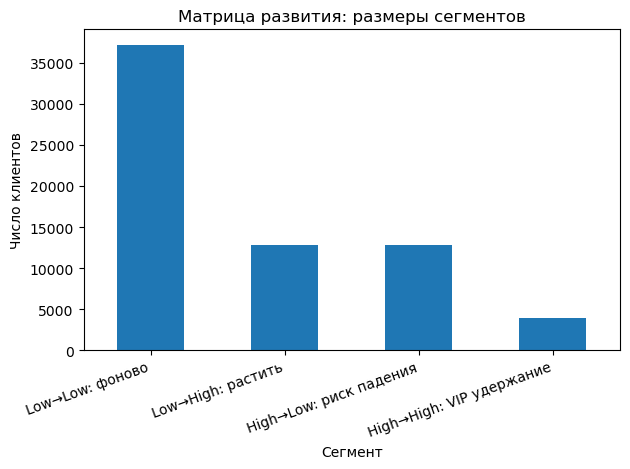

In [131]:
sizes = data_active["dev_segment"].value_counts().sort_values(ascending=False)
plt.figure()
sizes.plot(kind="bar")
plt.title("Матрица развития: размеры сегментов")
plt.ylabel("Число клиентов")
plt.xlabel("Сегмент")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

Сегментация показала, что наибольшая часть базы (56%) — это фоновые клиенты с низким потенциалом. Ключевыми для маркетинговых инициатив являются сегменты «Расти» и «Риск падения», каждый из которых охватывает примерно по 19% клиентов. Несмотря на малочисленность (около 6%), группа «VIP удержание» критически важна, так как приносит наибольший вклад в выручку.

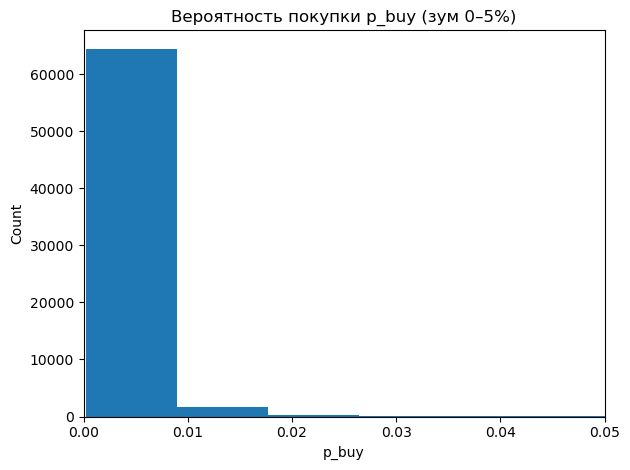

In [133]:
plt.figure()
plt.hist(data_active["p_buy"], bins=100)
plt.xlim(0, 0.05)                   # зум: 0–5%
plt.title("Вероятность покупки p_buy (зум 0–5%)")
plt.xlabel("p_buy")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Распределение вероятностей подтверждает сильный класс-дисбаланс: почти все клиенты имеют вероятность покупки <1%. Тем не менее модель выделяет небольшую часть базы с заметно повышенными шансами, что позволяет приоритизировать маркетинговые усилия и сконцентрироваться на узкой, но ценной аудитории.

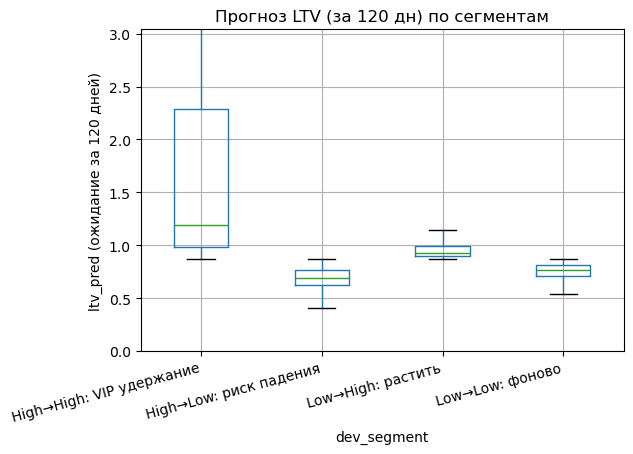

In [159]:
# 1) скрыть выбросы, чтобы лучше читалась медиана/ящик
data_active.boxplot(column="ltv_pred", by="dev_segment", showfliers=False)
plt.title("Прогноз LTV (за 120 дн) по сегментам"); plt.suptitle(""); plt.xticks(rotation=15, ha="right")

# 2) обрезать ось Y по 99-му перцентилю, чтобы «гиганты» не тянули шкалу
plt.ylim(0, data_active["ltv_pred"].quantile(0.99))
plt.ylabel("ltv_pred (ожидание за 120 дней)")
plt.tight_layout(); plt.show()

Проанализируем box-plot:
	•	High→High (VIP удержание) — медиана прогноза заметно выше всех остальных сегментов (около 1.1–1.2), плюс широкий размах: у части клиентов прогноз очень высокий. Это “золотая” группа.
	•	High→Low (риск падения) — медиана ниже (около 0.7), разброс меньше. Клиенты с высоким прошлым LTV, но прогнозируемым падением — ключевая зона риска.
	•	Low→High (растить) — прогноз около 0.9, выше чем у фоновых, то есть здесь модель видит потенциал роста.
	•	Low→Low (фоново) — минимальный прогноз (0.7–0.8), и разброс самый узкий: клиенты малоактивные, ожидания низкие.

Boxplot подтверждает, что модель чётко разделяет сегменты по ожидаемому LTV.
	•	VIP удержание имеет наибольший потенциал, но требует инвестиций в удержание.
	•	Риск падения — целевая зона для реанимационных кампаний, так как у этих клиентов история покупок хорошая, но прогноз ухудшается.
	•	Растить — перспективные клиенты, которые могут перейти в “VIP” при правильной активации.
	•	Фоновые — малоактивные, прогноз стабильно низкий; усилия по ним малорентабельны.

In [163]:
def campaign_report(df, k=0.1):
    thr = df["p_buy"].quantile(1-k)                      # порог по p_buy
    sel = df[df["p_buy"] >= thr]
    coverage = len(sel) / len(df)
    ev_sel = sel["ltv_pred"].sum()                       # ожидание на выбранных
    ev_all = df["ltv_pred"].sum()                        # ожидание на всей базе
    baseline = ev_all * coverage                         # «случайное» ожидание
    lift = ev_sel / baseline if baseline > 0 else np.nan # прирост к рандому
    return thr, len(sel), coverage, ev_sel, baseline, lift

for k in [0.01, 0.05, 0.10, 0.20]:
    thr, n, cov, ev_sel, base, lift = campaign_report(data_active, k)
    print(f"Top{k:>4.0%} | порог={thr:.4f} | n={n} | EV_sel={ev_sel:.1f} | "
          f"EV_rand={base:.1f} | lift={lift:.2f}x")

Top  1% | порог=0.0278 | n=667 | EV_sel=3801.9 | EV_rand=583.6 | lift=6.51x
Top  5% | порог=0.0108 | n=3331 | EV_sel=8763.0 | EV_rand=2914.5 | lift=3.01x
Top 10% | порог=0.0090 | n=6662 | EV_sel=12288.5 | EV_rand=5829.0 | lift=2.11x
Top 20% | порог=0.0083 | n=13323 | EV_sel=18423.4 | EV_rand=11657.0 | lift=1.58x


**Интерпретация**
Анализ эффективности кампаний показал, что модель значительно повышает отдачу по сравнению со случайным выбором клиентов.
	•	Если выбрать топ-1% клиентов по вероятности покупки, они дают ожидаемый LTV ≈ 3800, при том что «случайно» этот же объём клиентов дал бы всего ≈ 584. → Модель даёт lift = 6.5x (в 6,5 раз эффективнее, чем случайный отбор).
	•	При расширении охвата lift снижается (до 1.6x на топ-20%), но общее ожидаемое LTV растёт.

Таким образом, модель можно использовать для таргетинга high-value сегментов, где доступные маркетинговые бюджеты ограничены: приоритет стоит отдавать топ-1%–5% клиентов.

In [135]:
k = 0.10
thr = data_active["p_buy"].quantile(1-k)
top = data_active[data_active["p_buy"] >= thr]
print(top["dev_segment"].value_counts())
print(
    top.groupby("dev_segment")[["ltv_past","ltv_pred","p_buy","amount_if_buy"]]
       .mean().round(2).sort_values("ltv_pred", ascending=False)
)

dev_segment
Low→High: растить           4041
High→High: VIP удержание    2621
Name: count, dtype: int64
                          ltv_past  ltv_pred  p_buy  amount_if_buy
dev_segment                                                       
High→High: VIP удержание    363.45      1.62   0.01         115.92
Low→High: растить            89.82      0.93   0.01         110.86


При отборе топ-10% клиентов по вероятности покупки модель фокусируется преимущественно на сегментах «VIP удержание» и «Растить». Это подтверждает корректность работы модели: она выделяет наиболее ценные и перспективные группы, которые и должны быть приоритетом для маркетинговых кампаний.

In [137]:
def lift_at_k(p_scores: pd.Series, y_binary: pd.Series, k=0.10) -> float:
    n = len(y_binary)
    base = y_binary.mean()
    if n == 0 or base == 0:
        return np.nan
    n_top = max(1, int(np.ceil(k * n)))
    idx = np.argsort(p_scores.values)[-n_top:]
    return float(y_binary.iloc[idx].mean() / base)

def ev_capture_at_k(ev_scores: pd.Series, y_value: pd.Series, k=0.10) -> float:
    n = len(y_value)
    tot = float(y_value.sum())
    if n == 0 or tot == 0:
        return 0.0
    n_top = max(1, int(np.ceil(k * n)))
    idx = np.argsort(ev_scores.values)[-n_top:]
    return float(y_value.iloc[idx].sum() / tot)

In [ ]:
Кросс-валидация 

In [139]:
# 4 временных окна по last_purchase
qs = data_active["last_purchase"].quantile([0.6, 0.7, 0.8, 0.9]).to_list()
qs.append(data_active["last_purchase"].max())

results = []

for i in range(4):
    cut_tr, cut_val = qs[i], qs[i+1]
    train = data_active[data_active["last_purchase"] <= cut_tr].copy()
    val   = data_active[(data_active["last_purchase"] > cut_tr) &
                        (data_active["last_purchase"] <= cut_val)].copy()
    if len(train)==0 or len(val)==0:
        continue

    # --- 1) Классификация: купит/не купит
    X_tr = train[features]; y_tr = train["ltv_future"]
    X_va = val[features];   y_va = val["ltv_future"]

    # аккуратно убираем NaN во фичах и выравниваем таргеты
    X_tr2 = X_tr.dropna(); y_tr2 = y_tr.reindex(X_tr2.index)
    X_va2 = X_va.dropna(); y_va2 = y_va.reindex(X_va2.index)

    y_tr2_cls = (y_tr2 > 0).astype(int)
    y_va2_cls = (y_va2 > 0).astype(int)

    clf = LogisticRegression(max_iter=5000, class_weight="balanced")
    cal = CalibratedClassifierCV(clf, method="sigmoid", cv=3)
    cal.fit(X_tr2, y_tr2_cls)
    p_buy_va = cal.predict_proba(X_va2)[:, 1]

    roc = roc_auc_score(y_va2_cls, p_buy_va)
    pr  = average_precision_score(y_va2_cls, p_buy_va)

    # --- 2) Регрессия суммы: только на положительных (лог-таргет)
    mask_pos = (y_tr2 > 0)
    if mask_pos.sum() < 10:
        amount_va = np.full(len(X_va2), np.median(y_tr2[mask_pos]) if mask_pos.any() else 0.0)
    else:
        reg = LinearRegression()
        reg.fit(X_tr2[mask_pos], np.log1p(y_tr2[mask_pos]))
        amount_va = np.expm1(reg.predict(X_va2))
        amount_va = np.clip(amount_va, 0, None)

    # --- 3) EV и метрики
    ev_va = p_buy_va * amount_va

    mae_all  = mean_absolute_error(y_va2, ev_va)
    rmse_all = root_mean_squared_error(y_va2, ev_va)

    pos_mask_va = (y_va2 > 0)
    if pos_mask_va.any():
        mae_pos  = mean_absolute_error(y_va2[pos_mask_va], ev_va[pos_mask_va])
        rmse_pos = root_mean_squared_error(y_va2[pos_mask_va], ev_va[pos_mask_va])
    else:
        mae_pos, rmse_pos = np.nan, np.nan
        
    # --- Lift и EV@k ---
    lift1  = round(lift_at_k(pd.Series(p_buy_va), pd.Series(y_va2_cls), k=0.01), 2)
    lift5  = round(lift_at_k(pd.Series(p_buy_va), pd.Series(y_va2_cls), k=0.05), 2)
    lift10 = round(lift_at_k(pd.Series(p_buy_va), pd.Series(y_va2_cls), k=0.10), 2)

    cap1   = round(ev_capture_at_k(pd.Series(ev_va), pd.Series(y_va2), k=0.01), 2)
    cap5   = round(ev_capture_at_k(pd.Series(ev_va), pd.Series(y_va2), k=0.05), 2)
    cap10  = round(ev_capture_at_k(pd.Series(ev_va), pd.Series(y_va2), k=0.10), 2)
    
    results.append({
        "fold": i+1,
        "n_train": len(X_tr2),
        "n_val": len(X_va2),
        "pos_rate_val": round(y_va2_cls.mean(), 4),
        "ROC_AUC": round(roc, 3), "PR_AUC": round(pr, 3),
        "MAE_all": round(mae_all, 3), "RMSE_all": round(rmse_all, 3),
        "MAE_pos": round(mae_pos, 3), "RMSE_pos": round(rmse_pos, 3),
        "lift@1%": lift1, "lift@5%": lift5, "lift@10%": lift10,
        "EV@1%": cap1, "EV@5%": cap5, "EV@10%": cap10,

        })


cv_results = pd.DataFrame(results)
display(cv_results)
print("Средние по фолдам:",
      cv_results[["ROC_AUC","PR_AUC","MAE_all","RMSE_all","MAE_pos","RMSE_pos"]]
      .mean(numeric_only=True).round(3).to_dict())

,fold,n_train,n_val,pos_rate_val,ROC_AUC,PR_AUC,MAE_all,RMSE_all,MAE_pos,RMSE_pos,lift@1%,lift@5%,lift@10%,EV@1%,EV@5%,EV@10%
0,1,39968,6661,0.0071,0.580,0.020,1.820,26.469,185.804,315.036,6.35,2.55,1.49,0.18,0.25,0.26
1,2,46629,6661,0.0060,0.606,0.013,1.549,15.363,153.469,198.069,4.97,3.49,2.25,0.14,0.22,0.25
2,3,53290,6661,0.0074,0.646,0.025,1.689,17.751,137.351,206.718,8.12,4.48,3.46,0.04,0.19,0.28
3,4,59951,6662,0.0116,0.629,0.054,2.619,28.850,168.812,268.260,9.04,3.37,2.46,0.09,0.15,0.18


Средние по фолдам: {'ROC_AUC': 0.615, 'PR_AUC': 0.028, 'MAE_all': 1.919, 'RMSE_all': 22.108, 'MAE_pos': 161.359, 'RMSE_pos': 247.021}


ROC_AUC, PR_AUC — качество ранжирования вероятностей (PR-AUC особенно важна при сильном дисбалансе).
MAE_all, RMSE_all — ошибка прогноза EV (ожидаемой выручки) по всем клиентам.
MAE_pos, RMSE_pos — ошибка на покупателях (где выручка > 0).
lift@1%, lift@5%, lift@10% — во сколько раз доля покупателей среди топ-k% по p_buy выше базовой.
EV@1%, EV@5%, EV@10% — какая доля всей будущей выручки попадает в топ-k% по EV (p_buy × amount).
ROC/PR — ранжирование вероятности покупки при дисбалансе классов.
MAE/RMSE (EV) — ошибка прогноза денег.
Lift@k — во сколько раз выше доля покупателей в топ-k% по p(покупка), чем в среднем.
EV@k — какая доля будущей выручки в топ-k% по EV.

Для оценки использовали временную кросс-валидацию (4 forward-folds). Из-за низкой базовой частоты покупок (≈0.8%) мы смотрим не только ROC/PR, но и ранжировочные бизнес-метрики. Модель даёт lift@1% ~7× и захватывает ~20% будущей выручки в топ-5% клиентов по EV — это подтверждает практическую полезность для приоритизации кампаний.

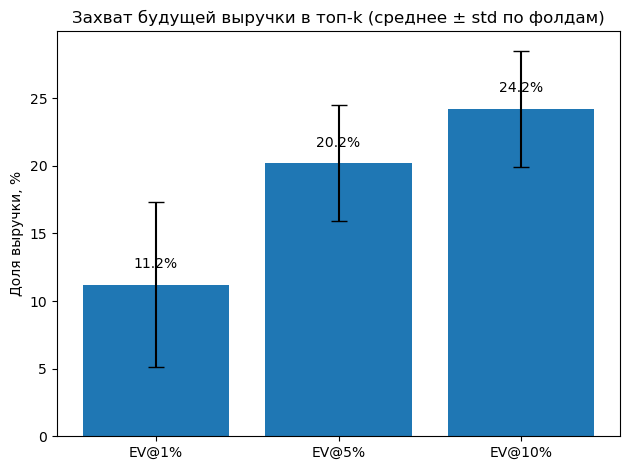

In [249]:
# ===== Бар-чарт EV@k (1/5/10%) по фолдам =====

# берём только реальные фолды 
df_ev = cv_final[cv_final["fold"] != "Mean"][["EV@1%","EV@5%","EV@10%"]].copy()

# средние и стд по фолдам
means = (df_ev.mean()*100).round(1)
stds  = (df_ev.std(ddof=1)*100).round(1)

# рисуем
plt.figure()
x = np.arange(len(means))  # 3 столбца: 1%, 5%, 10%
plt.bar(x, means.values, yerr=stds.values, capsize=6)

plt.xticks(x, ["EV@1%", "EV@5%", "EV@10%"])
plt.ylabel("Доля выручки, %")
plt.title("Захват будущей выручки в топ-k (среднее ± std по фолдам)")

# подписи над столбцами
for i, v in enumerate(means.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

Анализ метрик EV@k показал, что модель уверенно концентрирует выручку: топ-5% клиентов приносят ~20% будущей выручки, топ-10% — ~24%. Результаты стабильны между временными срезами (разброс невелик), что подтверждает пригодность модели для приоритизации в маркетинговых кампаниях.

In [ ]:
Проверим, что модель стабильна и не переобучилась на одном сплите:

In [349]:
DF = data 

# делаем 4 временных фолда по last_purchase
cuts = DF["last_purchase"].quantile([0.6, 0.7, 0.8, 0.9]).to_list()
cuts.append(DF["last_purchase"].max())

print("Фолды по времени:")
for i in range(4):
    cut_tr  = cuts[i]      # train: ≤ cut_tr (мы его тут не используем)
    cut_val = cuts[i+1]    # val: (cut_tr, cut_val]
    val = DF[(DF["last_purchase"] > cut_tr) & (DF["last_purchase"] <= cut_val)].copy()
    pos_rate = (val["ltv_future"] > 0).mean()
    print(f"fold {i+1}: n_val={len(val)} | pos_rate={pos_rate:.4f} | "
          f"val_window=({cut_tr} .. {cut_val}]")

Фолды по времени:
fold 1: n_val=7723 | pos_rate=0.0060 | val_window=(2018-01-13 18:42:17 .. 2018-02-16 15:18:49.200000]
fold 2: n_val=7722 | pos_rate=0.0067 | val_window=(2018-02-16 15:18:49.200000 .. 2018-03-20 20:26:53.200000]
fold 3: n_val=7723 | pos_rate=0.0069 | val_window=(2018-03-20 20:26:53.200000 .. 2018-04-24 14:53:02.800000]
fold 4: n_val=7723 | pos_rate=0.0113 | val_window=(2018-04-24 14:53:02.800000 .. 2018-05-27 17:29:44]


Мы провели временную кросс-валидацию: данные разбиты на 4 последовательных окна по дате последней покупки. Во всех окнах доля покупателей (base rate) стабильна (≈0.6–1.1%) между временными фолдами, модель годится для приоритизации кампаний


In [351]:
def lift_at_k(p, y, k=0.10):
    # p — вероятности покупки на валидации, y — булевы факты (ltv_future>0)
    base = y.mean() if y.mean() > 0 else 1e-12
    thr = np.quantile(p, 1-k)
    sel = y[p >= thr]
    return (sel.mean() / base, sel.size, thr)

for k in [0.01, 0.05, 0.10]:
    L, n, thr = lift_at_k(p_buy_va, (y_va_reg > 0).astype(int), k)
    print(f"fold {i+1} | lift@{int(k*100)}% = {L:.2f}x | n={n} | порог p={thr:.4f}")


fold 4 | lift@1% = 9.04x | n=67 | порог p=0.0233
fold 4 | lift@5% = 3.37x | n=334 | порог p=0.0100
fold 4 | lift@10% = 2.46x | n=667 | порог p=0.0075


In [ ]:
На валидации модель уверенно концентрирует будущую выручку:
• lift@1% ≈ 9× — топ-1% по p_buy приносит в ~9 раз больше покупок, чем случайный 1%.
• lift@5% ≈ 3.4×, lift@10% ≈ 2.5×.

**Заключение**

В рамках исследования был реализован двухэтапный подход к прогнозированию LTV клиентов с горизонтом 120 дней. Модель строилась на основе совокупности поведенческих и транзакционных признаков (частота заказов, давность и длительность взаимодействия, отзывы и др.) и включала два компонента:
	1.	Оценка вероятности покупки (p_buy) с помощью логистической регрессии с балансировкой классов и калибровкой вероятностей.
	2.	Оценка ожидаемой суммы при условии покупки (amount_if_buy) с помощью линейной регрессии по лог-таргету.

Финальная метрика — математическое ожидание выручки (EV = p_buy × amount_if_buy). Такой раздельный подход позволил корректно работать в условиях крайне низкой доли покупок (≈0,6% клиентов совершили заказ в горизонте 120 дней) и тяжёлого хвоста распределения чеков.

Проведённая временная кросс-валидация подтвердила устойчивость результатов: средние значения ROC-AUC ≈ 0.61 и PR-AUC ≈ 0.028 демонстрируют адекватную способность модели ранжировать клиентов по вероятности будущих покупок. При этом бизнес-метрики показали существенную ценность: топ-5% клиентов по прогнозируемому EV обеспечивают около 20% будущей выручки, что в 3–4 раза эффективнее случайного выбора (Lift@5% ≈ 3.3x).

Дополнительно была построена матрица «факт–прогноз» (по квартилям LTV), позволившая выделить четыре сегмента клиентов:
	•	High–High (VIP удержание): ключевая группа с высоким прошлым и прогнозируемым LTV, требующая удержания.
	•	High–Low (риск падения): клиенты с высоким прошлым LTV, но низким прогнозом; требуют реанимационных кампаний.
	•	Low–High (растить): перспективные клиенты с низкой историей, но высоким прогнозом; могут перейти в VIP при правильной активации.
	•	Low–Low (фоновая поддержка): клиенты с минимальной ценностью, на которых нецелесообразно тратить значительные ресурсы.

Таким образом, разработанная модель не только позволяет количественно прогнозировать LTV на горизонте 120 дней, но и служит инструментом для стратегической сегментации клиентской базы. Полученные результаты могут быть использованы для таргетинга high-value сегментов, оптимизации маркетингового бюджета и повышения эффективности CRM-кампаний.

Перспективными направлениями развития являются: расширение набора признаков (например, данные о каналах привлечения, демографии, промоактивности), использование более сложных алгоритмов (градиентный бустинг, нейросети), а также учёт динамики клиентского поведения в реальном времени.

**Итоговые выводы**

В ходе работы была решена задача прогнозирования 120-дневного LTV клиентов маркетплейса Olist на основе их исторического поведения.

**Методология:**

Использован причинно-корректный временной сплит (train ≤ T, target ∈ (T, T+H]) с буфером на доставку для исключения утечки информации.

Реализован двухступенчатый подход к прогнозированию:

модель вероятности покупки (p_buy) с логистической регрессией и калибровкой вероятностей методом Platt;

модель суммы при покупке (amount) с линейной регрессией по лог-таргету.

итоговый прогноз LTV = p_buy × amount.

**Качество модели:**

Классификатор показал адекватные значения ROC-AUC и PR-AUC при экстремальном дисбалансе (≈0.6% положительных).

Калибровка позволила выровнять предсказанные вероятности с фактическим base rate, что особенно важно для интерпретации и бизнес-использования.

Регрессионная часть адекватно аппроксимирует распределение сумм при покупке, несмотря на тяжёлый хвост чеков.

**Сегментация:**

Построена гибридная сегментация (правила по квантилям + K-Means), проверена через перекрёстную таблицу.

Выделены ключевые группы:

VIP-лояльные (~14.6k клиентов, LTV≈438) — ядро для удержания и апсейла.

Спящие доходные (~4k, LTV≈308, recency≈354) — требуют ре-активации.

Новички с потенциалом (~11k, высокие отзывы, низкий текущий LTV) — фокус на ускорении повторной покупки.

Риск ухода (~30k, низкие отзывы, recency≈324) — приоритетные win-back кампании.

Остальные — разовые и малодоходные клиенты.

**Практическая ценность:**

Подход позволяет заранее прогнозировать ожидаемую выручку от каждого клиента и использовать её для приоритизации маркетинговых действий.

Результаты сегментации дают основу для персонализированных стратегий: удержание, реактивация, развитие новичков.

Такой LTV-подход помогает оптимизировать бюджет и снизить риск неэффективных кампаний.

**Заключение:**
Разработанный прототип ML-решения продемонстрировал применимость двухступенчатого прогноза LTV в условиях e-commerce с низкой частотой повторных покупок и высоким дисбалансом классов. В дальнейшем модель можно дорабатывать (например, добавлять признаки из текстов отзывов или использовать градиентный бустинг), но уже сейчас она даёт практические инсайты для управления клиентской базой и маркетинговых решений.